# Recognize Indian Currency by using Transfer Learning

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

root_dir = '/content/drive/My Drive/'
base_dir = '/content/drive/My Drive/fastai-v3'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

     |████████████████████████████████| 390.9MB 116kB/s 
     |████████████████████████████████| 460kB 42.6MB/s 
     |████████████████████████████████| 3.8MB 30.0MB/s 


In [0]:
os.listdir(base_dir)

['Glasses-NoGlasses',
 'kaggle.json',
 'Currency-Dataset',
 'Indian-Currency-Dataset']

## Setup Input Pipeline

In [0]:
# path_data = base_dir + '/Indian-Currency-Dataset/train'
# path_test = base_dir + '/Indian-Currency-Dataset/test'
path_train_cropped = base_dir + '/Indian-Currency-Dataset/train-cropped'
path_valid_cropped = base_dir + '/Indian-Currency-Dataset/valid-cropped'
path_test_cropped = base_dir + '/Indian-Currency-Dataset/test-cropped'
path_aug = base_dir + '/Indian-Currency-Dataset/augmented_images'

os.listdir(base_dir + '/Indian-Currency-Dataset/')

['test', 'train', 'train-cropped', 'test-cropped', 'valid-cropped', 'models']

In [0]:
IMAGE_SIZE = 448
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 180,
    # brightness_range=[1.2, 0.7],
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    # fill_mode = 'constant',
    )

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    path_train_cropped,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    seed = 10,
    # save_to_dir = path_aug,
    # save_prefix = 'tr-0',
    # save_format = 'jpg',
    batch_size = BATCH_SIZE)

val_generator = test_datagen.flow_from_directory(
    path_valid_cropped,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    seed = 3)

test_generator = test_datagen.flow_from_directory(path_test_cropped,
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size=BATCH_SIZE)

Found 4407 images belonging to 9 classes.
Found 871 images belonging to 9 classes.
Found 294 images belonging to 9 classes.


In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights= 'imagenet')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalMaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
base_model.trainable = False

In [0]:
# model.load_weights(path_train_cropped + 'save/fine_tuning/save-weights-11-from120-MobNet.h5')

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 14, 14, 1280)      2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
activation_2 (Activation)    (None, 512)              

### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 229s 830ms/step - loss: 0.6080 - categorical_accuracy: 0.7928 - val_loss: 1.4335 - val_categorical_accuracy: 0.5614
Epoch 2/5
276/276 [==============================] - 221s 801ms/step - loss: 0.6099 - categorical_accuracy: 0.8001 - val_loss: 1.3289 - val_categorical_accuracy: 0.5959
Epoch 3/5
276/276 [==============================] - 221s 802ms/step - loss: 0.6034 - categorical_accuracy: 0.8010 - val_loss: 1.3506 - val_categorical_accuracy: 0.6005
Epoch 4/5
276/276 [==============================] - 222s 805ms/step - loss: 0.6209 - categorical_accuracy: 0.7935 - val_loss: 1.2869 - val_categorical_accuracy: 0.5993
Epoch 5/5
276/276 [==============================] - 223s 808ms/step - loss: 0.5801 - categorical_accuracy: 0.8078 - val_loss: 1.2914 - val_categorical_accuracy: 0.6062


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-top-mobnet.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 231s 837ms/step - loss: 0.5913 - categorical_accuracy: 0.8039 - val_loss: 1.3941 - val_categorical_accuracy: 0.5786
Epoch 2/5
276/276 [==============================] - 226s 818ms/step - loss: 0.5778 - categorical_accuracy: 0.8044 - val_loss: 1.4018 - val_categorical_accuracy: 0.5913
Epoch 3/5
276/276 [==============================] - 227s 821ms/step - loss: 0.5762 - categorical_accuracy: 0.8030 - val_loss: 1.4098 - val_categorical_accuracy: 0.5718
Epoch 4/5
276/276 [==============================] - 224s 812ms/step - loss: 0.5742 - categorical_accuracy: 0.8139 - val_loss: 1.1014 - val_categorical_accuracy: 0.6452
Epoch 5/5
276/276 [==============================] - 227s 822ms/step - loss: 0.5634 - categorical_accuracy: 0.8119 - val_loss: 1.1451 - val_categorical_accuracy: 0.6510


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-top-mobnet.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 233s 845ms/step - loss: 0.5281 - categorical_accuracy: 0.8273 - val_loss: 1.4029 - val_categorical_accuracy: 0.5947
Epoch 2/5
276/276 [==============================] - 222s 805ms/step - loss: 0.5498 - categorical_accuracy: 0.8123 - val_loss: 1.3804 - val_categorical_accuracy: 0.6108
Epoch 3/5
276/276 [==============================] - 234s 849ms/step - loss: 0.5412 - categorical_accuracy: 0.8146 - val_loss: 1.4144 - val_categorical_accuracy: 0.5890
Epoch 4/5
276/276 [==============================] - 231s 838ms/step - loss: 0.5510 - categorical_accuracy: 0.8060 - val_loss: 1.2828 - val_categorical_accuracy: 0.6269
Epoch 5/5
276/276 [==============================] - 230s 832ms/step - loss: 0.5418 - categorical_accuracy: 0.8226 - val_loss: 1.3117 - val_categorical_accuracy: 0.6234


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-3-top-mobnet.h5')

In [0]:
epochs = 5

history = model.fit_generator(train_generator,
                    epochs = epochs,
                    validation_data = val_generator)

Epoch 1/5
276/276 [==============================] - 425s 2s/step - loss: 0.5540 - categorical_accuracy: 0.8207 - val_loss: 0.7490 - val_categorical_accuracy: 0.7796
Epoch 2/5
276/276 [==============================] - 423s 2s/step - loss: 0.4980 - categorical_accuracy: 0.8312 - val_loss: 0.8104 - val_categorical_accuracy: 0.7543
Epoch 3/5
276/276 [==============================] - 423s 2s/step - loss: 0.5042 - categorical_accuracy: 0.8353 - val_loss: 0.8499 - val_categorical_accuracy: 0.7635
Epoch 4/5
276/276 [==============================] - 424s 2s/step - loss: 0.4574 - categorical_accuracy: 0.8462 - val_loss: 0.8799 - val_categorical_accuracy: 0.7382
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.4525 - categorical_accuracy: 0.8491 - val_loss: 0.7113 - val_categorical_accuracy: 0.7842


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-ResNet-top.h5')

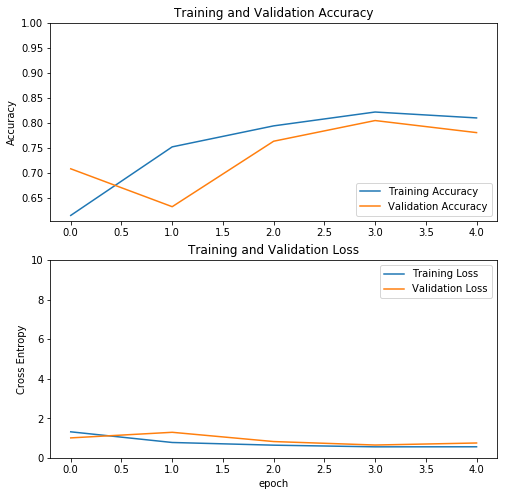

In [0]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
epochs = 40

history_1 = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/40
30/32 [===========================>..] - ETA: 2s - loss: 0.5543 - accuracy: 0.8525

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 58s 2s/step - loss: 0.5545 - accuracy: 0.8519 - val_loss: 4.2724 - val_accuracy: 0.3008
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 0.5564 - accuracy: 0.8428 - val_loss: 4.7080 - val_accuracy: 0.3171
Epoch 3/40
32/32 [==============================] - 49s 2s/step - loss: 0.4311 - accuracy: 0.8655 - val_loss: 5.3580 - val_accuracy: 0.2947
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.4088 - accuracy: 0.8705 - val_loss: 4.1000 - val_accuracy: 0.3516
Epoch 5/40
32/32 [==============================] - 49s 2s/step - loss: 0.3656 - accuracy: 0.8927 - val_loss: 5.6942 - val_accuracy: 0.3130
Epoch 6/40
32/32 [==============================] - 48s 2s/step - loss: 0.4129 - accuracy: 0.8670 - val_loss: 5.0287 - val_accuracy: 0.3130
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 0.3456 - accuracy: 0.8877 - val_loss: 4.8635 - val_accuracy: 0.3354
Epoch 8/40
32/32 [=============

In [0]:
model.save(path_data + '/save/fine_tuning/stage-2.h5')

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2.h5')

### Un-freeze the top layers of the model


In [0]:
# model.layers[0].trainable = True
# base_model.trainable = False
# model.load_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 105

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
# model.load_weights(path_train_cropped + '/save/fine_tuning/save-weights-16-from105-MobNet.h5')

### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['categorical_accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 14, 14, 1280)      2257984   
_________________________________________________________________
global_max_pooling2d (Global (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
activation (Activation)      (None, 512)               0

### Continue Train the model

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 230s 834ms/step - loss: 1.2406 - categorical_accuracy: 0.5623 - val_loss: 1.4247 - val_categorical_accuracy: 0.5373
Epoch 2/5
276/276 [==============================] - 222s 803ms/step - loss: 1.2007 - categorical_accuracy: 0.5816 - val_loss: 1.3968 - val_categorical_accuracy: 0.5454
Epoch 3/5
276/276 [==============================] - 219s 793ms/step - loss: 1.1939 - categorical_accuracy: 0.5836 - val_loss: 1.3501 - val_categorical_accuracy: 0.5476
Epoch 4/5
276/276 [==============================] - 222s 803ms/step - loss: 1.1084 - categorical_accuracy: 0.6088 - val_loss: 1.3708 - val_categorical_accuracy: 0.5396
Epoch 5/5
276/276 [==============================] - 219s 792ms/step - loss: 1.1341 - categorical_accuracy: 0.6040 - val_loss: 1.3647 - val_categorical_accuracy: 0.5476


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-1-from130-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 227s 823ms/step - loss: 1.0915 - categorical_accuracy: 0.6195 - val_loss: 1.3197 - val_categorical_accuracy: 0.5580
Epoch 2/5
276/276 [==============================] - 222s 805ms/step - loss: 1.0853 - categorical_accuracy: 0.6329 - val_loss: 1.2955 - val_categorical_accuracy: 0.5626
Epoch 3/5
276/276 [==============================] - 218s 789ms/step - loss: 1.0357 - categorical_accuracy: 0.6385 - val_loss: 1.3030 - val_categorical_accuracy: 0.5603
Epoch 4/5
276/276 [==============================] - 220s 799ms/step - loss: 1.0269 - categorical_accuracy: 0.6351 - val_loss: 1.3362 - val_categorical_accuracy: 0.5442
Epoch 5/5
276/276 [==============================] - 219s 794ms/step - loss: 0.9709 - categorical_accuracy: 0.6624 - val_loss: 1.3377 - val_categorical_accuracy: 0.5454


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-2-from150-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 228s 828ms/step - loss: 0.9951 - categorical_accuracy: 0.6637 - val_loss: 1.3595 - val_categorical_accuracy: 0.5442
Epoch 2/5
276/276 [==============================] - 222s 804ms/step - loss: 0.9468 - categorical_accuracy: 0.6778 - val_loss: 1.3679 - val_categorical_accuracy: 0.5327
Epoch 3/5
276/276 [==============================] - 221s 801ms/step - loss: 0.9315 - categorical_accuracy: 0.6839 - val_loss: 1.3013 - val_categorical_accuracy: 0.5545
Epoch 4/5
276/276 [==============================] - 221s 801ms/step - loss: 0.9271 - categorical_accuracy: 0.6862 - val_loss: 1.3095 - val_categorical_accuracy: 0.5603
Epoch 5/5
276/276 [==============================] - 222s 806ms/step - loss: 0.9215 - categorical_accuracy: 0.6869 - val_loss: 1.3210 - val_categorical_accuracy: 0.5591


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-3-from150-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 230s 835ms/step - loss: 0.9037 - categorical_accuracy: 0.6939 - val_loss: 1.3055 - val_categorical_accuracy: 0.5534
Epoch 2/5
276/276 [==============================] - 222s 805ms/step - loss: 0.8830 - categorical_accuracy: 0.6998 - val_loss: 1.2760 - val_categorical_accuracy: 0.5603
Epoch 3/5
276/276 [==============================] - 222s 805ms/step - loss: 0.8782 - categorical_accuracy: 0.7091 - val_loss: 1.3084 - val_categorical_accuracy: 0.5603
Epoch 4/5
276/276 [==============================] - 223s 807ms/step - loss: 0.8270 - categorical_accuracy: 0.7220 - val_loss: 1.3093 - val_categorical_accuracy: 0.5660
Epoch 5/5
276/276 [==============================] - 223s 807ms/step - loss: 0.8247 - categorical_accuracy: 0.7164 - val_loss: 1.3205 - val_categorical_accuracy: 0.5603


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-4-from145-MobNet.h')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 231s 838ms/step - loss: 0.8189 - categorical_accuracy: 0.7261 - val_loss: 1.3227 - val_categorical_accuracy: 0.5626
Epoch 2/5
276/276 [==============================] - 222s 805ms/step - loss: 0.8017 - categorical_accuracy: 0.7254 - val_loss: 1.3577 - val_categorical_accuracy: 0.5637
Epoch 3/5
276/276 [==============================] - 225s 817ms/step - loss: 0.8043 - categorical_accuracy: 0.7250 - val_loss: 1.3732 - val_categorical_accuracy: 0.5465
Epoch 4/5
276/276 [==============================] - 222s 804ms/step - loss: 0.7765 - categorical_accuracy: 0.7427 - val_loss: 1.3923 - val_categorical_accuracy: 0.5442
Epoch 5/5
276/276 [==============================] - 225s 816ms/step - loss: 0.7734 - categorical_accuracy: 0.7486 - val_loss: 1.3681 - val_categorical_accuracy: 0.5580


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-5-from145-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 228s 826ms/step - loss: 0.7469 - categorical_accuracy: 0.7529 - val_loss: 1.3542 - val_categorical_accuracy: 0.5568
Epoch 2/5
276/276 [==============================] - 225s 816ms/step - loss: 0.7445 - categorical_accuracy: 0.7463 - val_loss: 1.3262 - val_categorical_accuracy: 0.5603
Epoch 3/5
276/276 [==============================] - 225s 817ms/step - loss: 0.7266 - categorical_accuracy: 0.7647 - val_loss: 1.3413 - val_categorical_accuracy: 0.5603
Epoch 4/5
276/276 [==============================] - 223s 808ms/step - loss: 0.7033 - categorical_accuracy: 0.7620 - val_loss: 1.3270 - val_categorical_accuracy: 0.5672
Epoch 5/5
276/276 [==============================] - 224s 812ms/step - loss: 0.6970 - categorical_accuracy: 0.7656 - val_loss: 1.2720 - val_categorical_accuracy: 0.5775


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-6-from145-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 230s 832ms/step - loss: 0.7018 - categorical_accuracy: 0.7665 - val_loss: 1.3016 - val_categorical_accuracy: 0.5718
Epoch 2/5
276/276 [==============================] - 224s 813ms/step - loss: 0.6881 - categorical_accuracy: 0.7629 - val_loss: 1.2232 - val_categorical_accuracy: 0.5867
Epoch 3/5
276/276 [==============================] - 223s 807ms/step - loss: 0.6674 - categorical_accuracy: 0.7813 - val_loss: 1.2958 - val_categorical_accuracy: 0.5752
Epoch 4/5
276/276 [==============================] - 222s 805ms/step - loss: 0.6646 - categorical_accuracy: 0.7801 - val_loss: 1.2592 - val_categorical_accuracy: 0.5809
Epoch 5/5
276/276 [==============================] - 224s 812ms/step - loss: 0.6688 - categorical_accuracy: 0.7733 - val_loss: 1.2311 - val_categorical_accuracy: 0.5924


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-7-from145-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 230s 833ms/step - loss: 0.6586 - categorical_accuracy: 0.7781 - val_loss: 1.2636 - val_categorical_accuracy: 0.5809
Epoch 2/5
276/276 [==============================] - 222s 805ms/step - loss: 0.6467 - categorical_accuracy: 0.7878 - val_loss: 1.2843 - val_categorical_accuracy: 0.5867
Epoch 3/5
276/276 [==============================] - 218s 790ms/step - loss: 0.6238 - categorical_accuracy: 0.7860 - val_loss: 1.3216 - val_categorical_accuracy: 0.5637
Epoch 4/5
276/276 [==============================] - 222s 804ms/step - loss: 0.6149 - categorical_accuracy: 0.7933 - val_loss: 1.2791 - val_categorical_accuracy: 0.5683
Epoch 5/5
276/276 [==============================] - 222s 804ms/step - loss: 0.5943 - categorical_accuracy: 0.8017 - val_loss: 1.2106 - val_categorical_accuracy: 0.5901


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-8-from140-ResNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 1803s 7s/step - loss: 0.5791 - categorical_accuracy: 0.8083 - val_loss: 1.3104 - val_categorical_accuracy: 0.5706
Epoch 2/5
276/276 [==============================] - 294s 1s/step - loss: 0.5567 - categorical_accuracy: 0.8144 - val_loss: 1.3177 - val_categorical_accuracy: 0.5775
Epoch 3/5
276/276 [==============================] - 296s 1s/step - loss: 0.5370 - categorical_accuracy: 0.8248 - val_loss: 1.4475 - val_categorical_accuracy: 0.5465
Epoch 4/5
276/276 [==============================] - 301s 1s/step - loss: 0.5031 - categorical_accuracy: 0.8314 - val_loss: 1.3103 - val_categorical_accuracy: 0.5729
Epoch 5/5
276/276 [==============================] - 309s 1s/step - loss: 0.4873 - categorical_accuracy: 0.8462 - val_loss: 1.2868 - val_categorical_accuracy: 0.5752


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-9-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 322s 1s/step - loss: 0.4659 - categorical_accuracy: 0.8405 - val_loss: 1.1746 - val_categorical_accuracy: 0.6211
Epoch 2/5
276/276 [==============================] - 319s 1s/step - loss: 0.4597 - categorical_accuracy: 0.8534 - val_loss: 1.3443 - val_categorical_accuracy: 0.5706
Epoch 3/5
276/276 [==============================] - 320s 1s/step - loss: 0.4409 - categorical_accuracy: 0.8534 - val_loss: 1.2568 - val_categorical_accuracy: 0.5821
Epoch 4/5
276/276 [==============================] - 327s 1s/step - loss: 0.4225 - categorical_accuracy: 0.8645 - val_loss: 1.3675 - val_categorical_accuracy: 0.5580
Epoch 5/5
276/276 [==============================] - 332s 1s/step - loss: 0.4111 - categorical_accuracy: 0.8682 - val_loss: 1.4597 - val_categorical_accuracy: 0.5442


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-10-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 341s 1s/step - loss: 0.3893 - categorical_accuracy: 0.8727 - val_loss: 1.2893 - val_categorical_accuracy: 0.5786
Epoch 2/5
276/276 [==============================] - 337s 1s/step - loss: 0.3823 - categorical_accuracy: 0.8743 - val_loss: 1.1936 - val_categorical_accuracy: 0.6016
Epoch 3/5
276/276 [==============================] - 342s 1s/step - loss: 0.3644 - categorical_accuracy: 0.8886 - val_loss: 1.1417 - val_categorical_accuracy: 0.6131
Epoch 4/5
276/276 [==============================] - 347s 1s/step - loss: 0.3613 - categorical_accuracy: 0.8802 - val_loss: 1.0722 - val_categorical_accuracy: 0.6315
Epoch 5/5
276/276 [==============================] - 353s 1s/step - loss: 0.3532 - categorical_accuracy: 0.8816 - val_loss: 1.1480 - val_categorical_accuracy: 0.6108


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-10-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 374s 1s/step - loss: 0.3265 - categorical_accuracy: 0.8936 - val_loss: 1.1005 - val_categorical_accuracy: 0.6257
Epoch 2/5
276/276 [==============================] - 376s 1s/step - loss: 0.3289 - categorical_accuracy: 0.8961 - val_loss: 0.9130 - val_categorical_accuracy: 0.6797
Epoch 3/5
276/276 [==============================] - 385s 1s/step - loss: 0.3340 - categorical_accuracy: 0.8888 - val_loss: 0.9384 - val_categorical_accuracy: 0.6751
Epoch 4/5
276/276 [==============================] - 391s 1s/step - loss: 0.3172 - categorical_accuracy: 0.8988 - val_loss: 0.8591 - val_categorical_accuracy: 0.6900
Epoch 5/5
276/276 [==============================] - 401s 1s/step - loss: 0.3111 - categorical_accuracy: 0.9004 - val_loss: 0.9248 - val_categorical_accuracy: 0.6682


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-10-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 416s 2s/step - loss: 0.3013 - categorical_accuracy: 0.9063 - val_loss: 0.9068 - val_categorical_accuracy: 0.6866
Epoch 2/5
276/276 [==============================] - 415s 2s/step - loss: 0.2973 - categorical_accuracy: 0.9063 - val_loss: 0.8772 - val_categorical_accuracy: 0.6889
Epoch 3/5
276/276 [==============================] - 421s 2s/step - loss: 0.2846 - categorical_accuracy: 0.9138 - val_loss: 0.8451 - val_categorical_accuracy: 0.7061
Epoch 4/5
276/276 [==============================] - 421s 2s/step - loss: 0.2769 - categorical_accuracy: 0.9074 - val_loss: 0.8584 - val_categorical_accuracy: 0.6969
Epoch 5/5
276/276 [==============================] - 423s 2s/step - loss: 0.2800 - categorical_accuracy: 0.9095 - val_loss: 0.8747 - val_categorical_accuracy: 0.6912


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-11-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 499s 2s/step - loss: 0.2636 - categorical_accuracy: 0.9126 - val_loss: 0.8960 - val_categorical_accuracy: 0.6808
Epoch 2/5
276/276 [==============================] - 497s 2s/step - loss: 0.2572 - categorical_accuracy: 0.9192 - val_loss: 0.7376 - val_categorical_accuracy: 0.7325
Epoch 3/5
276/276 [==============================] - 469s 2s/step - loss: 0.2467 - categorical_accuracy: 0.9224 - val_loss: 0.6879 - val_categorical_accuracy: 0.7566
Epoch 4/5
276/276 [==============================] - 501s 2s/step - loss: 0.2411 - categorical_accuracy: 0.9199 - val_loss: 0.6617 - val_categorical_accuracy: 0.7761
Epoch 5/5
276/276 [==============================] - 517s 2s/step - loss: 0.2256 - categorical_accuracy: 0.9253 - val_loss: 0.6825 - val_categorical_accuracy: 0.7646


In [0]:
#from 110
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-12-from120-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 1607s 6s/step - loss: 0.2442 - categorical_accuracy: 0.9192 - val_loss: 0.6234 - val_categorical_accuracy: 0.7830
Epoch 2/5
276/276 [==============================] - 225s 816ms/step - loss: 0.2164 - categorical_accuracy: 0.9319 - val_loss: 0.6399 - val_categorical_accuracy: 0.7773
Epoch 3/5
276/276 [==============================] - 224s 813ms/step - loss: 0.2090 - categorical_accuracy: 0.9315 - val_loss: 0.6024 - val_categorical_accuracy: 0.7945
Epoch 4/5
276/276 [==============================] - 225s 814ms/step - loss: 0.2194 - categorical_accuracy: 0.9265 - val_loss: 0.6457 - val_categorical_accuracy: 0.7704
Epoch 5/5
276/276 [==============================] - 224s 811ms/step - loss: 0.1936 - categorical_accuracy: 0.9371 - val_loss: 0.5843 - val_categorical_accuracy: 0.7979


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-13-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 234s 847ms/step - loss: 0.1875 - categorical_accuracy: 0.9426 - val_loss: 0.5278 - val_categorical_accuracy: 0.8232
Epoch 2/5
276/276 [==============================] - 223s 809ms/step - loss: 0.1892 - categorical_accuracy: 0.9403 - val_loss: 0.5063 - val_categorical_accuracy: 0.8232
Epoch 3/5
276/276 [==============================] - 224s 810ms/step - loss: 0.1831 - categorical_accuracy: 0.9403 - val_loss: 0.4652 - val_categorical_accuracy: 0.8439
Epoch 4/5
276/276 [==============================] - 223s 808ms/step - loss: 0.1866 - categorical_accuracy: 0.9378 - val_loss: 0.4397 - val_categorical_accuracy: 0.8519
Epoch 5/5
276/276 [==============================] - 223s 808ms/step - loss: 0.1863 - categorical_accuracy: 0.9421 - val_loss: 0.5485 - val_categorical_accuracy: 0.8152


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-14-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 231s 838ms/step - loss: 0.1695 - categorical_accuracy: 0.9440 - val_loss: 0.5182 - val_categorical_accuracy: 0.8186
Epoch 2/5
276/276 [==============================] - 227s 823ms/step - loss: 0.1555 - categorical_accuracy: 0.9505 - val_loss: 0.5208 - val_categorical_accuracy: 0.8048
Epoch 3/5
276/276 [==============================] - 226s 820ms/step - loss: 0.1713 - categorical_accuracy: 0.9480 - val_loss: 0.5610 - val_categorical_accuracy: 0.7945
Epoch 4/5
276/276 [==============================] - 227s 823ms/step - loss: 0.1583 - categorical_accuracy: 0.9530 - val_loss: 0.5591 - val_categorical_accuracy: 0.7956
Epoch 5/5
276/276 [==============================] - 223s 809ms/step - loss: 0.1444 - categorical_accuracy: 0.9535 - val_loss: 0.4698 - val_categorical_accuracy: 0.8347


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-15-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 2,
                         validation_data=val_generator)

Epoch 1/2
276/276 [==============================] - 235s 852ms/step - loss: 0.1471 - categorical_accuracy: 0.9542 - val_loss: 0.4788 - val_categorical_accuracy: 0.8289
Epoch 2/2
276/276 [==============================] - 222s 805ms/step - loss: 0.1432 - categorical_accuracy: 0.9526 - val_loss: 0.4088 - val_categorical_accuracy: 0.8645


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-15-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 2,
                         validation_data=val_generator)

Epoch 1/2
276/276 [==============================] - 232s 841ms/step - loss: 0.1461 - categorical_accuracy: 0.9528 - val_loss: 0.4150 - val_categorical_accuracy: 0.8760
Epoch 2/2
276/276 [==============================] - 222s 805ms/step - loss: 0.1346 - categorical_accuracy: 0.9605 - val_loss: 0.3338 - val_categorical_accuracy: 0.8921


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-16-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 1620s 6s/step - loss: 0.1245 - categorical_accuracy: 0.9632 - val_loss: 0.3688 - val_categorical_accuracy: 0.8772
Epoch 2/5
276/276 [==============================] - 230s 832ms/step - loss: 0.1212 - categorical_accuracy: 0.9626 - val_loss: 0.3800 - val_categorical_accuracy: 0.8760
Epoch 3/5
276/276 [==============================] - 232s 840ms/step - loss: 0.1237 - categorical_accuracy: 0.9612 - val_loss: 0.3257 - val_categorical_accuracy: 0.8944
Epoch 4/5
276/276 [==============================] - 226s 819ms/step - loss: 0.1307 - categorical_accuracy: 0.9582 - val_loss: 0.3625 - val_categorical_accuracy: 0.8852
Epoch 5/5
276/276 [==============================] - 235s 852ms/step - loss: 0.1296 - categorical_accuracy: 0.9594 - val_loss: 0.3727 - val_categorical_accuracy: 0.8794


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-17-from105-MobNet.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs = 5,
                         validation_data=val_generator)

Epoch 1/5
276/276 [==============================] - 231s 835ms/step - loss: 0.1081 - categorical_accuracy: 0.9666 - val_loss: 0.4127 - val_categorical_accuracy: 0.8565
Epoch 2/5
276/276 [==============================] - 228s 827ms/step - loss: 0.1014 - categorical_accuracy: 0.9687 - val_loss: 0.4062 - val_categorical_accuracy: 0.8726
Epoch 3/5
276/276 [==============================] - 225s 815ms/step - loss: 0.1072 - categorical_accuracy: 0.9671 - val_loss: 0.4151 - val_categorical_accuracy: 0.8691
Epoch 4/5
276/276 [==============================] - 225s 814ms/step - loss: 0.0970 - categorical_accuracy: 0.9671 - val_loss: 0.3893 - val_categorical_accuracy: 0.8749
Epoch 5/5
276/276 [==============================] - 232s 842ms/step - loss: 0.1077 - categorical_accuracy: 0.9641 - val_loss: 0.3101 - val_categorical_accuracy: 0.9001


In [0]:
model.save_weights(path_train_cropped + '/save/fine_tuning/save-weights-18-from105-MobNet.h5')

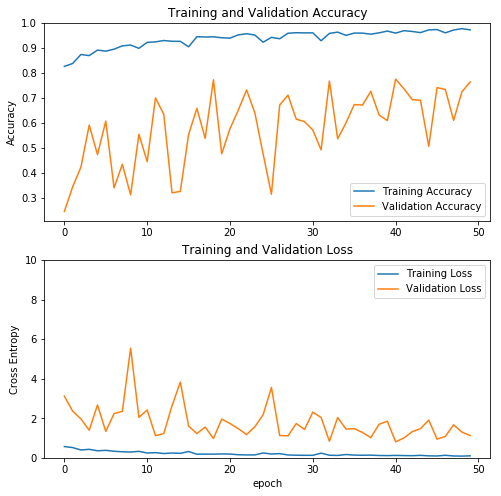

In [0]:
acc = history_fine.history['categorical_accuracy']
val_acc = history_fine.history['val_categorical_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs = 10,
                         validation_data=val_generator)

Epoch 1/10
262/262 [==============================] - 551s 2s/step - loss: 0.0718 - categorical_accuracy: 0.9763 - val_loss: 3.2012 - val_categorical_accuracy: 0.6750
Epoch 2/10
262/262 [==============================] - 533s 2s/step - loss: 0.0962 - categorical_accuracy: 0.9723 - val_loss: 2.0268 - val_categorical_accuracy: 0.6788
Epoch 3/10
262/262 [==============================] - 525s 2s/step - loss: 0.0721 - categorical_accuracy: 0.9782 - val_loss: 3.0902 - val_categorical_accuracy: 0.6308
Epoch 4/10
262/262 [==============================] - 514s 2s/step - loss: 0.0666 - categorical_accuracy: 0.9792 - val_loss: 2.0423 - val_categorical_accuracy: 0.7202
Epoch 5/10
262/262 [==============================] - 536s 2s/step - loss: 0.0650 - categorical_accuracy: 0.9813 - val_loss: 1.1903 - val_categorical_accuracy: 0.7933
Epoch 6/10
262/262 [==============================] - 509s 2s/step - loss: 0.0813 - categorical_accuracy: 0.9739 - val_loss: 2.3755 - val_categorical_accuracy: 0.697

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2-from2.h5')

#Validation Testing

In [0]:
y_pred = model.predict_generator(val_generator)

In [0]:
labels = val_generator.classes
filenames = val_generator.filenames

In [0]:
probs = y_pred[:, 0]

#Testing

In [0]:
model.evaluate(test_generator)

19/19 [==============================] - 79s 4s/step - loss: 5.4265 - categorical_accuracy: 0.1701


[5.426527675829436, 0.17006803]

In [0]:
from sklearn.utils.multiclass import unique_labels

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.BrBG):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

###On Train

In [0]:
train_generator.shuffle = False

In [0]:
Y_pred = model.predict_generator(train_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
print(confusion_matrix(train_generator.classes[train_generator.index_array], y_pred))
print(classification_report(train_generator.classes[train_generator.index_array], y_pred))

276/276 [==============================] - 201s 729ms/step
[[512   1   0  12   8   0   1   1   0]
 [ 57 159   7 103 225   5  10   0   0]
 [ 17   0 310 168  69   0  12   5   0]
 [ 14   0   3 502   4   0   0   0   0]
 [ 23   0   1  16 461   1   0   0   0]
 [ 39   1   1  16 210 262   4   3   0]
 [ 18   0   6  92  14   0 424   0   0]
 [ 32   0  14  19 101   0   1 355   0]
 [  0   0   0  77   0   0   0   0  11]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       535
           1       0.99      0.28      0.44       566
           2       0.91      0.53      0.67       581
           3       0.50      0.96      0.66       523
           4       0.42      0.92      0.58       502
           5       0.98      0.49      0.65       536
           6       0.94      0.77      0.84       554
           7       0.98      0.68      0.80       522
           8       1.00      0.12      0.22        88

    accuracy                           0.68    

Confusion matrix, without normalization
[[514   0   0  12   6   1   1   1   0]
 [ 58 149   8  95 238   6  11   1   0]
 [ 25   0 303 146  86   0  13   8   0]
 [ 16   0   1 504   1   1   0   0   0]
 [ 28   0   2  17 454   1   0   0   0]
 [ 28   2   3  13 238 246   3   2   1]
 [ 13   0   8 101   9   0 422   1   0]
 [ 29   0  16  18  89   1   6 363   0]
 [  2   0   0  76   0   0   0   0  10]]


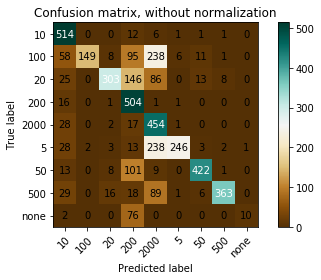

In [0]:
plot_confusion_matrix(train_generator.classes[train_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)

###On Validation

In [0]:
val_generator.shuffle = False

55/55 [==============================] - 284s 5s/step
Confusion matrix, without normalization
[[119   1   0   3   1   0   0   0   0]
 [  1  35   8  11  16   0   1   0   0]
 [  1   0  65   1   1   0   0   0   0]
 [  1   0   0  74   0   0   0   0   0]
 [  2   0   2   1 102   0   0   0   0]
 [  6   1   6   3  43  59   4   2   0]
 [  0   0   6   9   3   0  81   0   0]
 [ 12   0  15   1  27   0   0 124   0]
 [  0   0   0  16   0   0   0   0   7]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       124
           1       0.95      0.49      0.64        72
           2       0.64      0.96      0.76        68
           3       0.62      0.99      0.76        75
           4       0.53      0.95      0.68       107
           5       1.00      0.48      0.64       124
           6       0.94      0.82      0.88        99
           7       0.98      0.69      0.81       179
           8       1.00      0.30      0.47        23

    accuracy

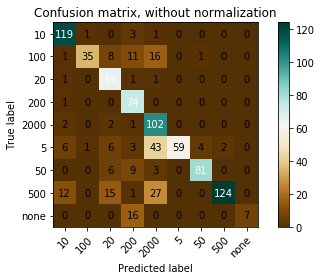

In [0]:
Y_pred = model.predict_generator(val_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)
plot_confusion_matrix(val_generator.classes[val_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000', '5', '50', '500', 'none']), False)
print(classification_report(val_generator.classes[val_generator.index_array], y_pred))

###On Test

In [0]:
test_generator.shuffle = False

In [0]:
Y_pred = model.predict_generator(test_generator, verbose = 1)
y_pred = np.argmax(Y_pred, axis = 1)

19/19 [==============================] - 3s 150ms/step


Confusion matrix, without normalization
[[21  0 20  8  8  0  0  0  0]
 [23  2  4  2 30  0  0  1  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 5  0  3 10  3  0 22  0  0]
 [ 0  0  0  4  0  0  0  1  0]
 [ 3  8  1  2  7  1  2  0  0]
 [ 1  0  2  3 35  0  1  0  0]
 [ 3  0  1  1  6  0  0 11  0]
 [13  0  2  7  4  0  3  0  0]]


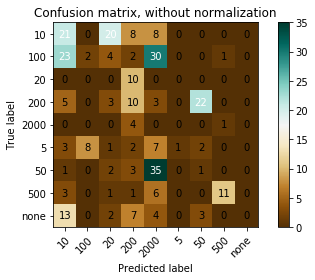

In [0]:
plot_confusion_matrix(test_generator.classes[test_generator.index_array], y_pred, np.array(['10', '100', '20', '200', '2000','5', '50', '500', 'none']), False)

Confusion matrix, without normalization
[[21  0 20  8  8  0  0  0  0]
 [23  2  4  2 30  0  0  1  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 5  0  3 10  3  0 22  0  0]
 [ 0  0  0  4  0  0  0  1  0]
 [ 3  8  1  2  7  1  2  0  0]
 [ 1  0  2  3 35  0  1  0  0]
 [ 3  0  1  1  6  0  0 11  0]
 [13  0  2  7  4  0  3  0  0]]


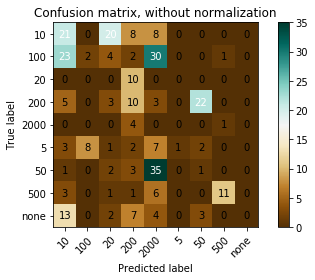

In [0]:
plot_confusion_matrix(test_generator.classes, y_pred, np.array(['10', '100', '20', '200', '2000','5', '50', '500', 'none']), False)

In [0]:
print(classification_report(test_generator.classes[test_generator.index_array], y_pred))

              precision    recall  f1-score   support

           0       0.30      0.37      0.33        57
           1       0.20      0.03      0.06        62
           2       0.00      0.00      0.00        10
           3       0.21      0.23      0.22        43
           4       0.00      0.00      0.00         5
           5       1.00      0.04      0.08        24
           6       0.04      0.02      0.03        42
           7       0.85      0.50      0.63        22
           8       0.00      0.00      0.00        29

    accuracy                           0.16       294
   macro avg       0.29      0.13      0.15       294
weighted avg       0.28      0.16      0.17       294



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Convert to TFLite

In [0]:
saved_model_dir = path_train_cropped + '/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(saved_model_dir + '/model-8-MobNet-448.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/fastai-v3/Indian-Currency-Dataset/train-cropped/save/fine_tuning/assets


In [0]:
saved_model_dir

'/content/drive/My Drive/fastai-v3/Indian-Currency-Dataset/train-cropped/save/fine_tuning'

Download the converted model and labels

In [0]:
from google.colab import files

files.download(saved_model_dir + '/model-8-MobNet-448.tflite')
# files.download('labels.txt')

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()